Author: Gautam Ojha

**Sms Spam Classifier Using Natural Language Processing**

**Importing Important Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**1. Inspecting the dataset**

In [2]:
df = pd.read_table('SMSSpamCollection.txt', header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
0    5572 non-null object
1    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [4]:
y = df[0]
y.value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

 We need to encode the class labels in the target variable as numbers to ensure compatibility with some models in Scikit-learn. Because we have binary classes, let's use LabelEncoder and set 'spam' = 1 and 'ham' = 0.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [6]:
y_enc = le.fit_transform(y)

In [7]:
y_enc

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [8]:
raw_text = df[1]

**2. Text preprocessing**

**2.1. Normalization**

In [9]:
example = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """

Instead of removing the following terms, for each training example, let's replace them with a specific string.

1)Replace email addresses with 'emailaddr'
2)Replace URLs with 'httpaddr'
3)Replace money symbols with 'moneysymb'
4)Replace phone numbers with 'phonenumbr'
5)Replace numbers with 'numbr'

In [11]:

processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')
processed = processed.str.replace(r'£|\$', 'moneysymb')    
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')    
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

Removing punctuation and Whitespace

In [12]:

processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')



Converting to lower String

In [13]:
processed = processed.str.lower()

**2.2. Removing stop words**

In [14]:
import nltk
from nltk.corpus import stopwords

In [15]:
stop_words = nltk.corpus.stopwords.words('english')

In [16]:
processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in set(stop_words)))

**2.3. Stemming**

In [17]:
from nltk.stem import PorterStemmer

In [19]:
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

Let's combine them all into a handy function that takes in a string and cleans it up.

In [20]:

import re
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )



In [21]:

(processed == raw_text.apply(preprocess_text)).all()



True

In [22]:

preprocess_text(example)



'congratl numbr ticket hamilton nyc httpaddr worth moneysymbnumbr call phonenumbr send messag emailaddr get ticket'

**3. Feature engineering**

In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer



In [24]:

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(processed)



In [25]:

X_ngrams.shape



(5572, 36348)

**4. Training and evaluating a model**

In [26]:

from sklearn.model_selection import train_test_split
from sklearn import svm



In [27]:

X_train, X_test, y_train, y_test = train_test_split(X_ngrams,y_enc,test_size=0.2,random_state=42,stratify=y_enc)



In [28]:

clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)



In [29]:

from sklearn import metrics



In [30]:

metrics.f1_score(y_test, y_pred)



0.9285714285714286

In [31]:

pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),index=[['actual', 'actual'], ['spam', 'ham']],columns=[['predicted', 'predicted'], ['spam', 'ham']])



predicted     
                 spam  ham
actual spam       965    1
       ham         19  130

In [32]:

from sklearn.model_selection import cross_val_score



In [33]:

sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')



Diagnosing the model with learning curves

In [34]:

from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
train_sizes, train_scores, valid_scores = learning_curve(estimator=svm.LinearSVC(loss='hinge', C=1e10),X=X_ngrams,y=y_enc,train_sizes=sample_space,cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),scoring='f1',n_jobs=-1)



In [35]:

def make_tidy(sample_space, train_scores, valid_scores):
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )



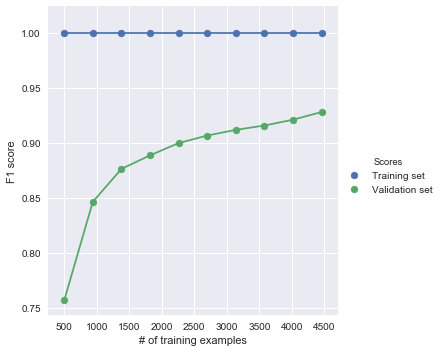

In [36]:

g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();



Using nested cross-validation to minimize information leakage¶

In [39]:

from sklearn.model_selection import GridSearchCV

param_grid = [{'C': np.logspace(-4, 4, 20)}]

grid_search = GridSearchCV(estimator=svm.LinearSVC(loss='hinge'),param_grid=param_grid,cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),scoring='f1',n_jobs=-1)

scores = cross_val_score(estimator=grid_search,X=X_ngrams,y=y_enc,cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),scoring='f1',n_jobs=-1)



In [40]:
scores

array([ 0.91636364,  0.94366197,  0.95104895,  0.93661972,  0.94736842,
        0.93286219,  0.91039427,  0.90510949,  0.9057971 ,  0.94699647])

In [41]:

scores.mean()



0.92962222115832238

**5. What terms are the top predictors of spam?**

In [42]:

grid_search.fit(X_ngrams, y_enc)
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);



In [43]:

pd.Series(final_clf.coef_.T.ravel(),index=vectorizer.get_feature_names()).sort_values(ascending=False)[:20]



phonenumbr         5.008632
numbrp             2.799187
txt                2.690817
moneysymbnumbr     2.557430
call phonenumbr    2.251019
rington            2.098571
servic             2.049273
mobil              2.036899
numbr              1.896237
tone               1.831285
repli              1.664237
text               1.603975
claim              1.590065
video              1.473552
free               1.359939
wap                1.336547
stop               1.310738
credit             1.278886
uk                 1.239139
order              1.227617
dtype: float64

In [44]:

def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'



In [45]:

spam_filter(example)



'spam'

**Own Example**

In [46]:
spam_filter('Ohhh, you won 50,000')

'spam'

In [47]:
spam_filter("Gautam, here!")

'not spam'